[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/gist/napsternxg/c7a50835bb7db81ca0d3883115bf7dec)


Code in this notebook is based on https://github.com/ghostktjMactavish/Adversarial-Autoencoders/blob/master/AAE.py

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model


import numpy as np
from tqdm import tqdm

import matplotlib

matplotlib.use('Agg')

import matplotlib.pyplot as plt

plt.ioff()

from IPython.display import Image, display, HTML

In [0]:
e_h_1=1000
e_h_2=1000
encoded_dim=8
d_h_1=1000
d_h_2=1000
disc_h_1=1000
disc_h_2=1000
img_shape=(28,28)

#lr=0.0037 ideal lr Very Important On my machine


def get_encoder(initializer):
  """Encoder model"""
  model_key = "encoder"
  encoder = Sequential([
    Reshape(img_shape+(1,), input_shape=img_shape, name=f"{model_key}_flatten"),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    Conv2D(8, (3, 3), activation='relu', padding='same')
    
  ], name=model_key)
  x_input=Input(img_shape, name=f"{model_key}_input")
  reshape_layer=(x_input)
  encoder_hidden_1=Dense(
      e_h_1,activation='relu',
      kernel_initializer=initializer,
      bias_initializer=initializer,
      name=f"{model_key}_h1"
  )(flatten_layer)
  encoder_hidden_2=Dense(
      e_h_2,activation='relu',
      kernel_initializer=initializer,
      bias_initializer=initializer,
      name=f"{model_key}_h2"
  )(encoder_hidden_1)
  z_code=Dense(
      encoded_dim,activation='linear',
      kernel_initializer=initializer,
      bias_initializer=initializer,
      name=f"{model_key}_z"
  )(encoder_hidden_2)
  encoder=Model(inputs=x_input,outputs=z_code, name=model_key)
  return encoder


def get_decoder(initializer):
  """Decoder model"""
  model_key = "decoder"
  d_x_input=Input((encoded_dim,), name=f"{model_key}_input")
  decoder_hidden_1=Dense(
      d_h_1,activation='relu',
      kernel_initializer=initializer,
      bias_initializer=initializer,
      name=f"{model_key}_h1"
  )(d_x_input)
  decoder_hidden_2=Dense(
      d_h_2,activation='relu',
      kernel_initializer=initializer,
      bias_initializer=initializer,
      name=f"{model_key}_h2"
  )(decoder_hidden_1)
  decoder_image=Dense(
      np.prod(img_shape), activation='sigmoid',
      kernel_initializer=initializer,
      bias_initializer=initializer,
      name=f"{model_key}_image"
  )(decoder_hidden_2)
  gen_img=Reshape(img_shape, name=f"{model_key}_reshape")(decoder_image)

  decoder=Model(inputs=d_x_input,outputs=gen_img, name=model_key)
  return decoder


def get_autoencoder(encoder, decoder):
  """AutoEncoder model"""
  model_key = "autoencoder"
  img=Input(shape=img_shape, name=f"{model_key}_input")
  encoded_repr=encoder(img)
  recons_img=decoder(encoded_repr)
  autoencoder=Model(inputs=img,outputs=recons_img)
  return autoencoder


def get_discriminator_layer(initializer):
  """Discriminator layer which will be reused by multiple models"""
  model_key = "discriminator_layer"
  disc_x_input=Input((encoded_dim,), name=f"{model_key}_input")
  disc_hidden_1=Dense(
      disc_h_1,activation='relu',
      kernel_initializer=initializer,
      bias_initializer=initializer, 
      name=f"{model_key}_h1"
  )(disc_x_input)
  disc_hidden_2=Dense(
      disc_h_2,activation='relu',
      kernel_initializer=initializer,
      bias_initializer=initializer,
      name=f"{model_key}_h2"
  )(disc_hidden_1)
  real_or_fake=Dense(
      1, activation='sigmoid',
      kernel_initializer=initializer,
      bias_initializer=initializer,
      name=f"{model_key}_real_or_fake"
  )(disc_hidden_2)
  discriminator_layer = Model(inputs=disc_x_input, outputs=real_or_fake, name=model_key)
  return discriminator_layer


def get_discriminator(discriminator_layer):
  """Discriminator model"""
  model_key = "discriminator"
  disc_x_input=Input((encoded_dim,), name=f"{model_key}_input")
  real_or_fake=discriminator_layer(disc_x_input)
  discriminator=Model(inputs=disc_x_input, outputs=real_or_fake, name=model_key)
  return discriminator


def get_encoder_discriminator(encoder, discriminator_layer):
  """Encoder discriminator"""
  img=Input(shape=img_shape)
  encoded_repr=encoder(img)
  confidence=discriminator_layer(encoded_repr)
  encoder_discriminator=Model(inputs=img, outputs=confidence)
  return encoder_discriminator


def get_models():
  """Get all the models"""
  optimizer_reconst=Adam(0.0037)
  optimizer_discriminator=Adam(0.0005)
  optimizer_encoder_discriminator=Adam(0.0007)

  initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)

  encoder = get_encoder(initializer)
  decoder = get_decoder(initializer)
  # Need discriminator_base to avoid placeholder error when joining models
  discriminator_layer = get_discriminator_layer(initializer)
  discriminator = get_discriminator(discriminator_layer)
  autoencoder = get_autoencoder(encoder, decoder)
  encoder_discriminator = get_encoder_discriminator(encoder, discriminator_layer)


  autoencoder.compile(optimizer=optimizer_reconst, loss='binary_crossentropy')
  discriminator.compile(optimizer=optimizer_discriminator,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
  for layer in discriminator.layers:
      layer.trainable=False
  encoder_discriminator.compile(optimizer=optimizer_encoder_discriminator,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
  return encoder, decoder, discriminator, autoencoder, encoder_discriminator


def generate_images(decoder, n=100):
  """Generate sample of images using decoder"""
  latents = 5*np.random.normal(size=(n, encoded_dim))
  images = decoder.predict(latents)
  return images

def imagegrid(epoch, images, prefix, nrows=10, size = 2):
  """Plot image grid"""
  ncols = np.ceil(images.shape[0]/nrows)
  fig = plt.figure(figsize=[size*ncols, size*nrows])
  for i, img in enumerate(images):
    img = img.reshape((28, 28))
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.set_axis_off()
    ax.imshow(img, cmap="gray")
  plt.suptitle(prefix)
  plt.savefig(f"images/{prefix}_{epoch}.png")
  plt.show()
  plt.close(fig)




Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
autoencoder_input (InputLaye (None, 28, 28)            0         
_________________________________________________________________
encoder (Model)              (None, 8)                 1794008   
_________________________________________________________________
decoder (Model)              (None, 28, 28)            1794784   
Total params: 3,588,792
Trainable params: 3,588,792
Non-trainable params: 0
_________________________________________________________________


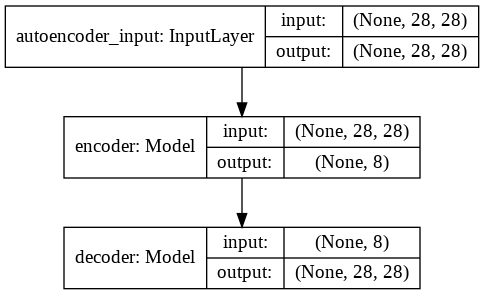

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa (None, 8)                 0         
_________________________________________________________________
discriminator_layer (Model)  (None, 1)                 1011001   
Total params: 2,022,002
Trainable params: 1,011,001
Non-trainable params: 1,011,001
_________________________________________________________________


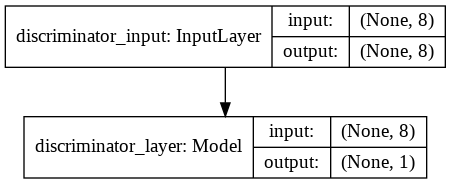

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
encoder (Model)              (None, 8)                 1794008   
_________________________________________________________________
discriminator_layer (Model)  (None, 1)                 1011001   
Total params: 2,805,009
Trainable params: 1,794,008
Non-trainable params: 1,011,001
_________________________________________________________________


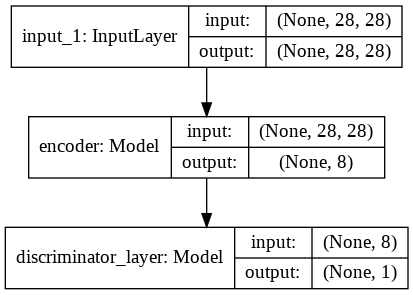

In [0]:
K.clear_session()
encoder, decoder, discriminator, autoencoder, encoder_discriminator = get_models()


model_names = [
    "autoencoder",
    "discriminator",
    "encoder_discriminator"
]
for name, model in zip(
    model_names, [
    autoencoder, 
    discriminator,
    encoder_discriminator
]):
    model.summary()
    plot_model(
        model,
        to_file=f'{name}.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB'
    )
    display(HTML(f"<h1>{name}</h1>"))
    display(Image(f"./{name}.png"))

## Train model

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255.
x_test = x_test.astype(np.float32) / 255.

x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [0]:
# Cleanup images directory
! mkdir -p ./images
! rm ./images/*
##Training
epochs=5000
save_interval=500
batch_size=200
all_metrics = []
with tqdm(total=epochs, desc="Epoch: ") as pbar:
  for epoch in range(epochs):
    pbar.set_description(f"Epoch {epoch:5d}")
    epoch_metrics = {}
    half_batch=int(batch_size/2)

    idx = np.random.randint(0, x_train.shape[0], half_batch)
    imgs=x_train[idx]
    latent_fake=encoder.predict(imgs)
    latent_real= 5*np.random.normal(size=(half_batch, encoded_dim))
    valid =0.9*np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    d_loss_real, d_loss_real_acc = discriminator.train_on_batch(latent_real, valid)
    d_loss_fake, d_loss_fake_acc = discriminator.train_on_batch(latent_fake, fake)
    d_loss = 0.5 * (d_loss_real+d_loss_fake)
    d_acc = 0.5 * (d_loss_real_acc+d_loss_fake_acc)
    d_metrics = {
      "d_loss_real": d_loss_real,
      "d_loss_fake": d_loss_fake,
      "d_loss": d_loss,
      "d_loss_real_acc": d_loss_real_acc,
      "d_loss_fake_acc": d_loss_fake_acc,
      "d_acc": d_acc                    
    }
    epoch_metrics.update(d_metrics)
    #idx = np.random.randint(0, x_train.shape[0], batch_size)
    #imgs = x_train[idx]
    valid_y = 0.9*np.ones((half_batch, 1))
    g_loss_reconstruction = autoencoder.train_on_batch(imgs, imgs)
    ae_loss_reconstruction = autoencoder.train_on_batch(imgs, imgs)
    ae_metrics = {
      "ae_loss": ae_loss_reconstruction
    }
    epoch_metrics.update(ae_metrics)
    #for i in range(5):
    g_loss_ce, g_acc = encoder_discriminator.train_on_batch(imgs, valid_y)
    g_metrics = {
      "g_loss_ce": g_loss_ce,
      "g_acc": g_acc
    }
    #self.callbacks["encoder_discriminator"].on_epoch_end(epoch, g_metrics)
    epoch_metrics.update(g_metrics)
    # Plot the progress                
    pbar.set_postfix(**epoch_metrics)
    pbar.update(1)
    epoch_metrics["epoch"] = epoch
    all_metrics.append(epoch_metrics)
    if(epoch % save_interval == 0):
      imagegrid(epoch, decoder.predict(latent_real), prefix="sampled")
      imagegrid(epoch, imgs, prefix="original")
      imagegrid(epoch, autoencoder.predict(imgs), prefix="reconstructed")

Epoch     0:   0%|          | 0/5000 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


Epoch  4999: 100%|██████████| 5000/5000 [04:33<00:00, 23.91it/s, ae_loss=0.112, d_acc=0.48, d_loss=0.425, d_loss_fake=0.255, d_loss_fake_acc=0.96, d_loss_real=0.595, d_loss_real_acc=0, g_acc=0, g_loss_ce=1.78]


## Save the model

In [0]:
model_names = [
    "autoencoder",
    "discriminator",
    "encoder_discriminator"
]
for name, model in zip(
    model_names, [
    autoencoder, 
    discriminator,
    encoder_discriminator
]):
    model.save(f'{name}.h5')

## Plot embedding space

In [0]:

%matplotlib inline

import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
sns.set_context("talk")
sns.set_style("ticks")

In [0]:
train_embeddings = encoder.predict(x_train)
test_embeddings = encoder.predict(x_test)
train_embeddings.shape, test_embeddings.shape

((60000, 8), (10000, 8))

In [0]:
pca = PCA(n_components=2)
pca_train = pca.fit_transform(train_embeddings)
pca_test = pca.transform(test_embeddings)

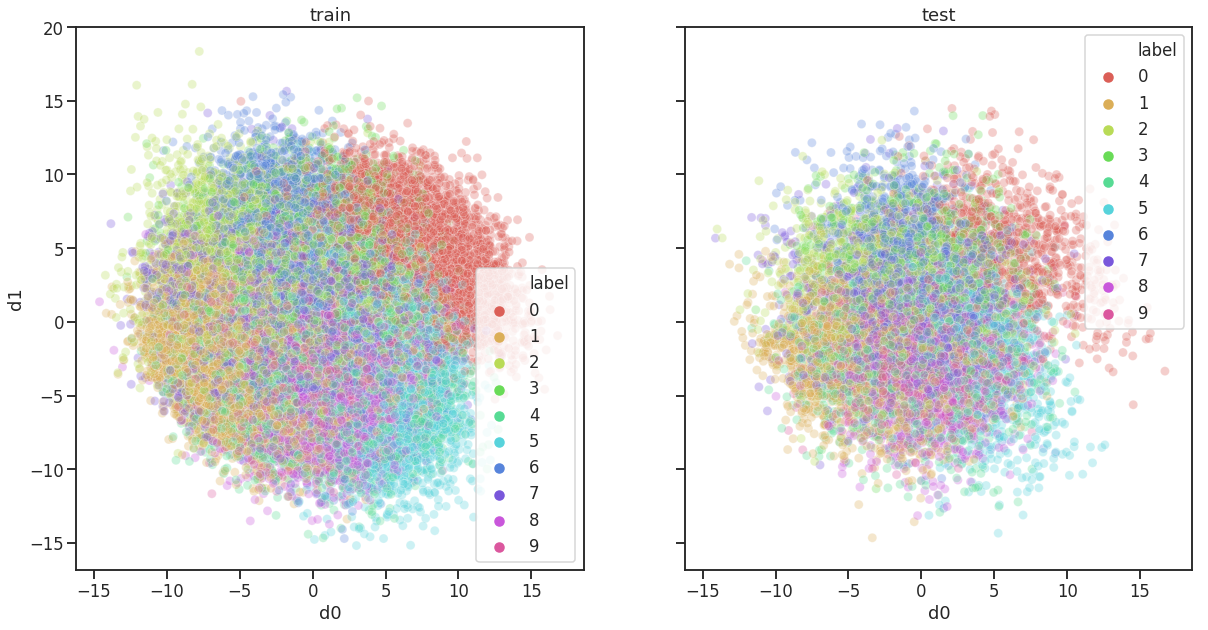

In [0]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20, 10))
for axi, title, pca_output, y in zip(
    ax, ["train", "test"], [pca_train, pca_test], [y_train, y_test]
): 
  sns.scatterplot(
      x="d0", y="d1",
      hue="label",
      palette=sns.color_palette("hls", 10),
      data=pd.DataFrame({
          "d0": pca_output[:, 0],
          "d1": pca_output[:, 1],
          "label": y
      }),
      legend="full",
      alpha=0.3,
      ax=axi
  )
  axi.set_title(title)

In [0]:
%%time
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_train = tsne.fit_transform(train_embeddings)
tsne_test = tsne.fit_transform(test_embeddings)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.056s...
[t-SNE] Computed neighbors for 60000 samples in 20.543s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for s

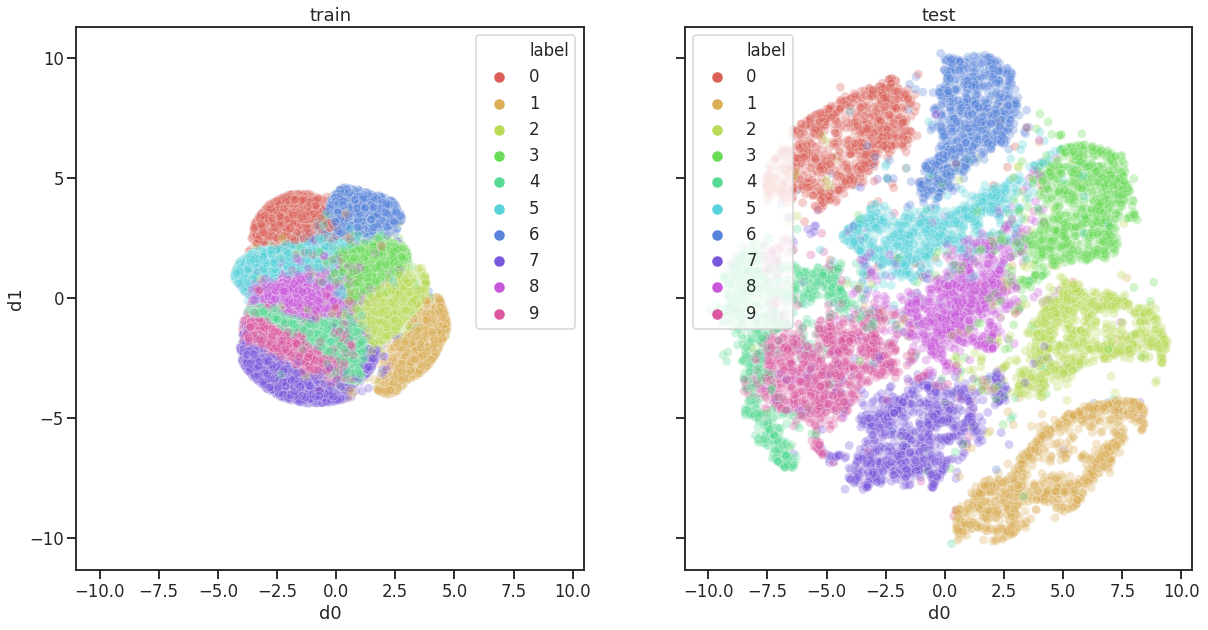

In [0]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20, 10))
for axi, title, pca_output, y in zip(
    ax, ["train", "test"], [tsne_train, tsne_test], [y_train, y_test]
): 
  sns.scatterplot(
      x="d0", y="d1",
      hue="label",
      palette=sns.color_palette("hls", 10),
      data=pd.DataFrame({
          "d0": pca_output[:, 0],
          "d1": pca_output[:, 1],
          "label": y
      }),
      legend="full",
      alpha=0.3,
      ax=axi
  )
  axi.set_title(title)

In [0]:
df = pd.DataFrame(all_metrics)
df.head()

,ae_loss,d_acc,d_loss,d_loss_fake,d_loss_fake_acc,d_loss_real,d_loss_real_acc,epoch,g_acc,g_loss_ce
0,0.687726,0.0,0.696924,0.700925,0.0,0.692922,0.0,0,0.0,0.686575
1,0.637173,0.0,0.662483,0.704523,0.0,0.620443,0.0,1,0.0,0.644018
2,0.887614,0.0,0.696113,0.833062,0.0,0.559163,0.0,2,0.0,0.559611
3,0.364988,0.0,0.747716,0.982472,0.0,0.512959,0.0,3,0.0,0.668052
4,0.433164,0.0,0.612343,0.732388,0.0,0.492297,0.0,4,0.0,0.674551


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fac8ac9fdd8>,
      dtype=object)

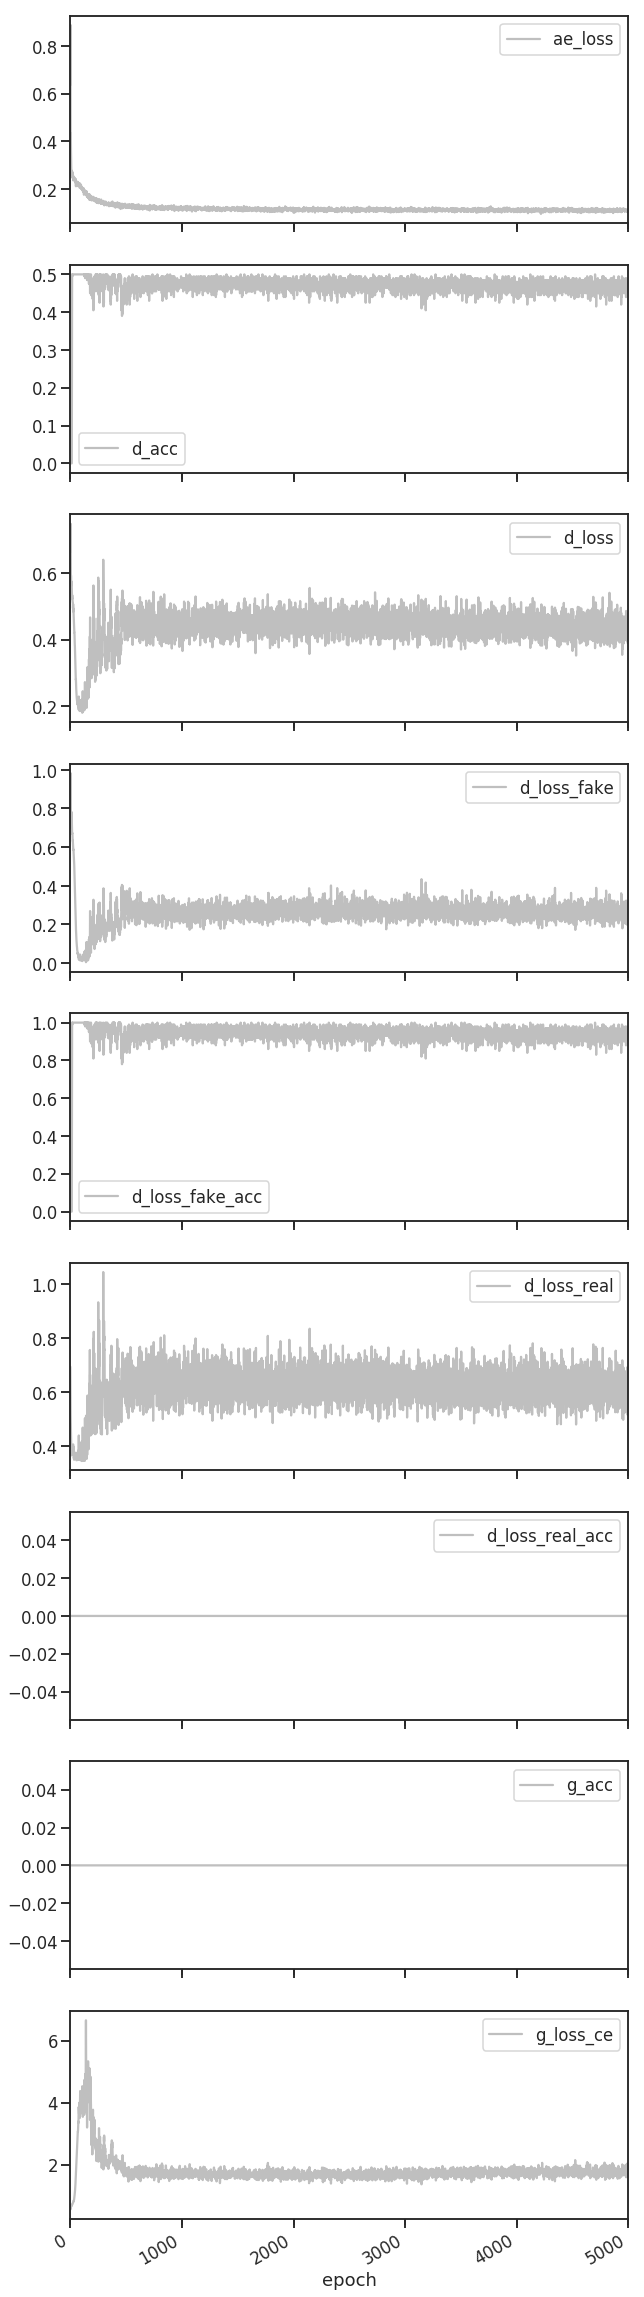

In [0]:
df.plot(x="epoch", kind="line", subplots=True, color="0.5", alpha=0.5, figsize=(10, 5*(df.shape[1]-1)))

## Mean embeddings

In [0]:
digit_mean_latents = []
for i in range(10):
  mean_embedding = train_embeddings[y_train==i].mean(axis=0)
  std_embedding = train_embeddings[y_train==i].std(axis=0)
  latents = np.random.normal(loc=mean_embedding, scale=std_embedding*0.5, size=(10, encoded_dim))
  digit_mean_latents.append(latents)
digit_mean_latents = np.vstack(digit_mean_latents)
digit_mean_latents.shape

(100, 8)

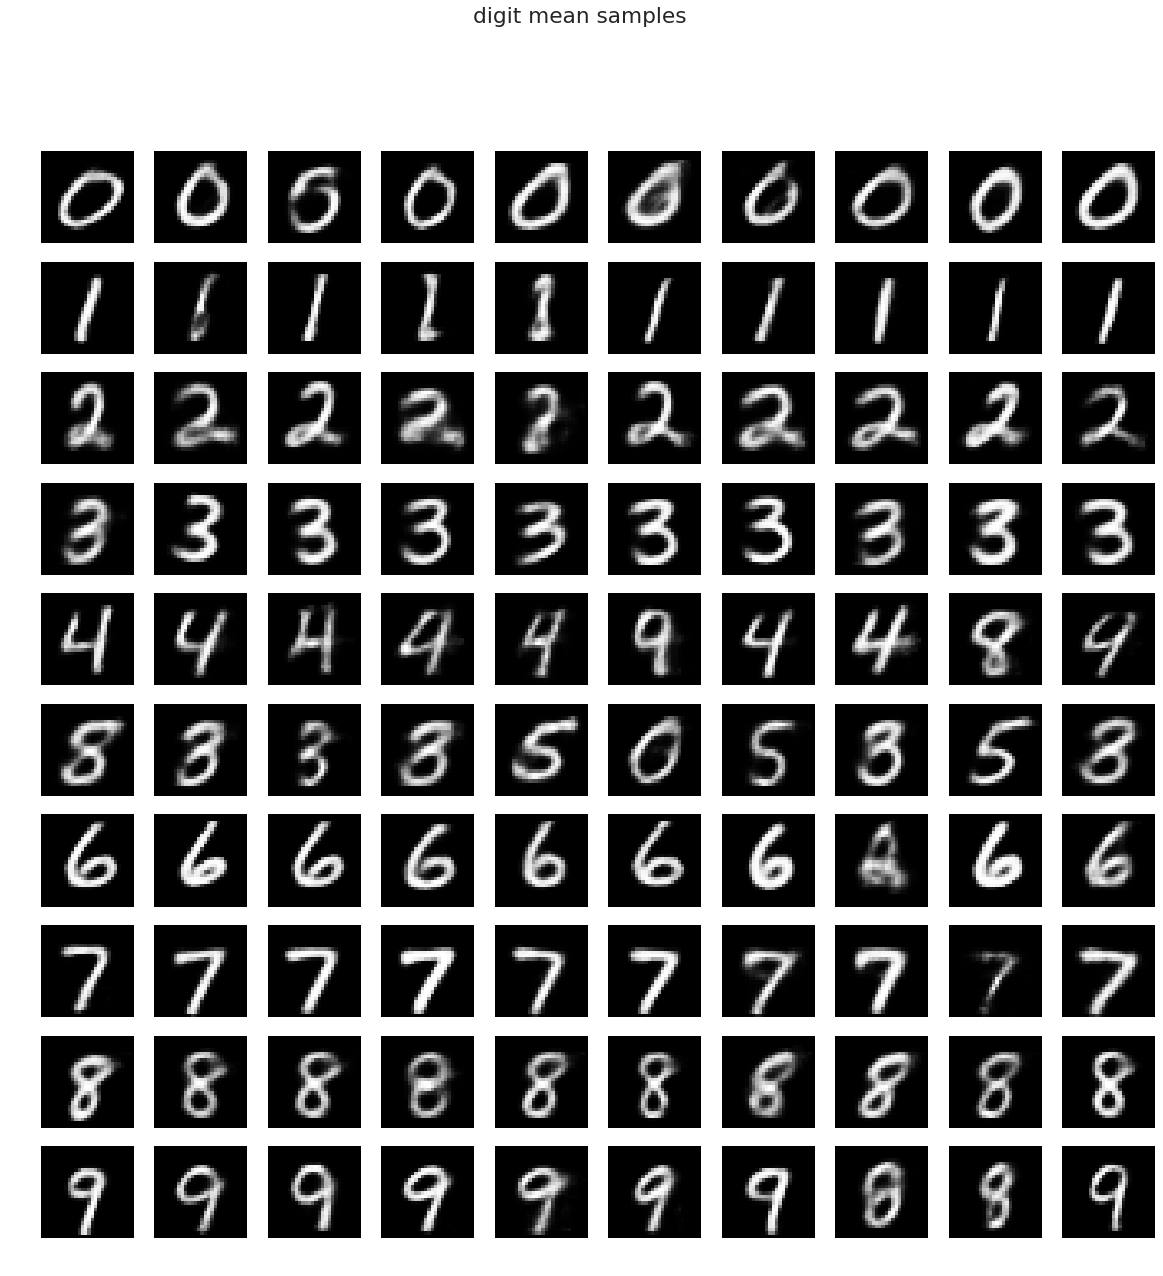

In [0]:
images = decoder.predict(digit_mean_latents)
imagegrid(epoch, images, "digit mean samples")

## Plot distribution of discriminator scores

Text(0.5, 1.0, 'True')

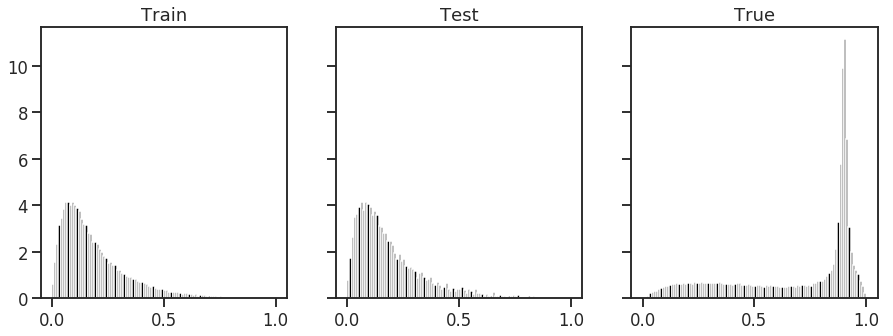

In [0]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15, 5))
ax[0].hist(
    discriminator.predict(train_embeddings).flatten(), 
    bins=np.arange(0,1.01, 0.01), density=True,
    label="train",
    color="k"
)
ax[0].set_title("Train")
ax[1].hist(
    discriminator.predict(test_embeddings).flatten(), 
    bins=np.arange(0,1.01, 0.01), density=True,
    label="test",
    color="k"
)
ax[1].set_title("Test")
true_latent_samples = 5*np.random.normal(size=(train_embeddings.shape[0], encoded_dim))
ax[2].hist(
    discriminator.predict(true_latent_samples).flatten(), 
    bins=np.arange(0,1.01, 0.01), density=True,
    label="test",
    color="k"
)
ax[2].set_title("True")

## Reconstruction from test

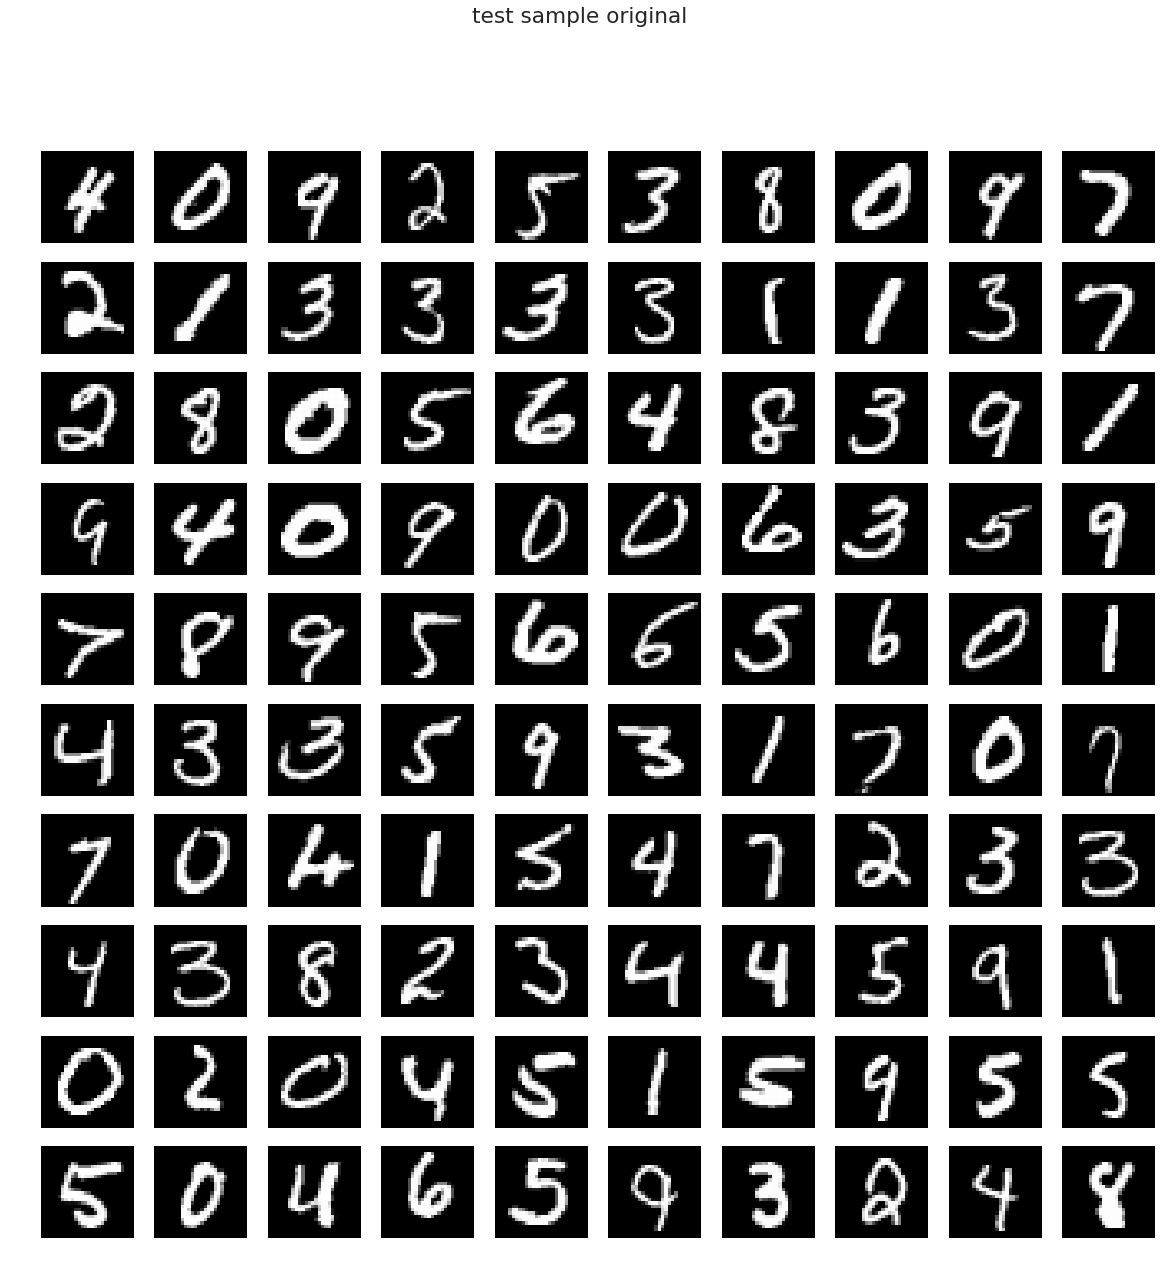

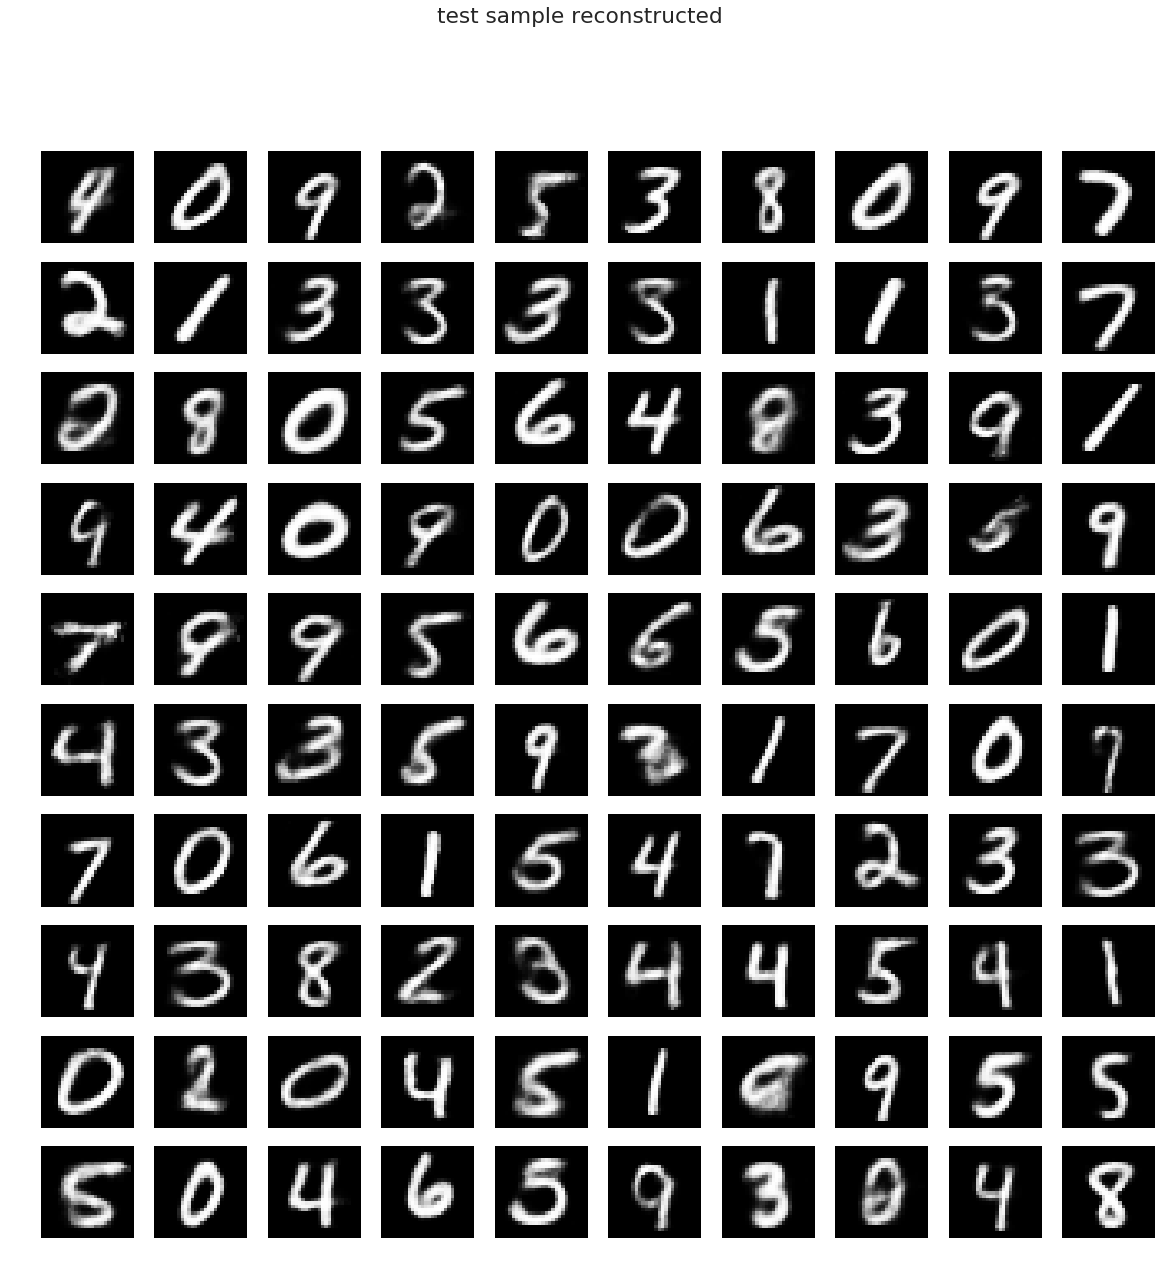

In [51]:
idx = np.random.randint(0, x_test.shape[0], half_batch)
test_images=x_test[idx]
reconstructed_test_images=autoencoder.predict(test_images)
imagegrid(epoch, test_images, "test sample original")
imagegrid(epoch, reconstructed_test_images, "test sample reconstructed")

(100, 28, 28)


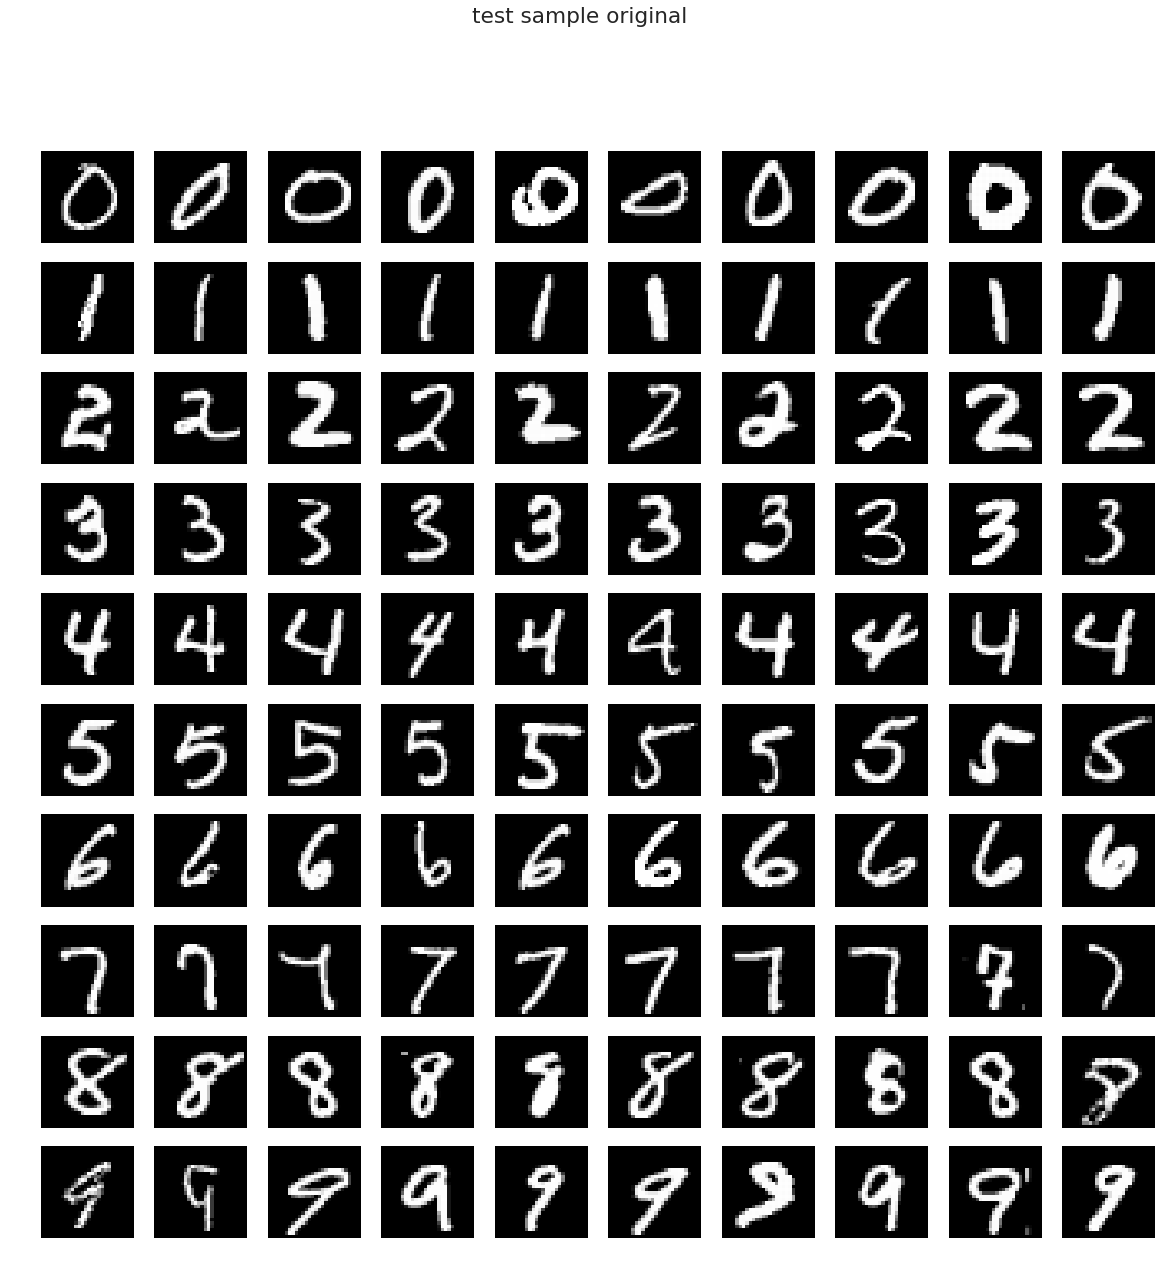

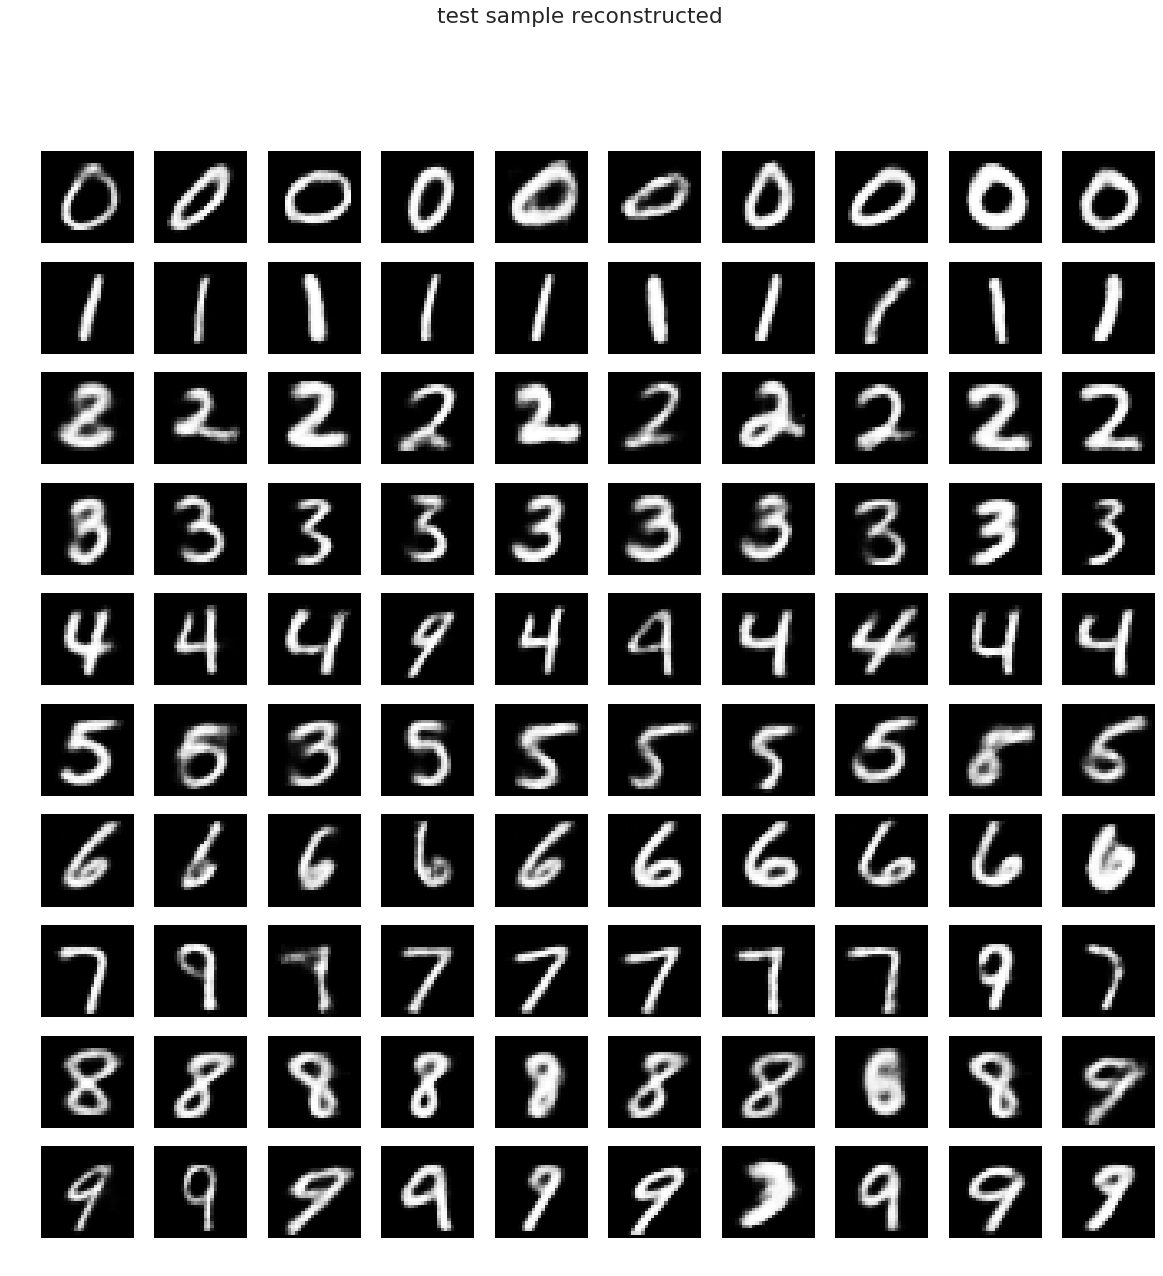

In [54]:
test_images_per_digit = []
for i in range(10):
  idx = np.random.randint(0, x_test[y_test==i].shape[0], 10)
  test_images=x_test[y_test==i][idx]
  test_images_per_digit.append(test_images)
test_images_per_digit = np.vstack(test_images_per_digit)
print(test_images_per_digit.shape)
reconstructed_test_images=autoencoder.predict(test_images_per_digit)
imagegrid(epoch, test_images_per_digit, "test sample original")
imagegrid(epoch, reconstructed_test_images, "test sample reconstructed")